In [2]:
import numpy as np
import numba as nb
from matplotlib import pyplot as plt


plt.rcParams["font.sans-serif"] = "SimHei"  # 确保plt绘图正常显示中文# 加载 MNIST 数据集  


获取数据方法
```py
import tensorflow as tf  
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
```
然后可以将`mnist.npz`

从`C:\Users\<YourUsername>\.keras\datasets\mnist.npz`复制出来


In [3]:
data_path = './data/mnist_data.npz'

def one_hot_encode(y):
    num_classes = len(np.unique(y))
    return np.eye(num_classes)[y]

# 拆分数据集为训练集和测试集
data = np.load(data_path)
x_train, y_train, x_test, y_test = data['x_train'], data['y_train'], data['x_test'], data['y_test']


# 将图像归一化到 [0, 1]
x_train = x_train.astype('float32') / 255.0  # 归一化到 [0, 1]  
x_test = x_test.astype('float32') / 255.0
# 将标签转换为 one-hot 编码
y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

print(f"训练集:\t\t{x_train.shape}")
print(f"训练集标签:\t{y_train.shape}")
print(f"测试集:\t\t{x_test.shape}") 
print(f"测试集标签:\t{y_test.shape}")

训练集:		(60000, 28, 28)
训练集标签:	(60000, 10)
测试集:		(10000, 28, 28)
测试集标签:	(10000, 10)


In [4]:
# print(f"训练集标签:\n{y_train[:25]}")

# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(x_train[i], cmap='gray')
#     plt.axis('off')
# plt.show()

In [5]:
# 基类
class Layer:
    training = True
    debug = False
    
    def __init__(self, *args, **kwargs) -> None:
        super().__setattr__('training', True)
        self.dW = None
        self.db = None

    def forward(self, *args, **kwargs):
        raise NotImplementedError
    
    def backward(self, *args, **kwargs):
        raise NotImplementedError
    
    def update(self, *args, **kwargs):
        raise NotImplementedError

# 卷积父类
# 主要会复用im2col和col2im函数
class ConvLayer(Layer):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        
    def im2col(self, x, kernel_size, stride, padding):
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        filter_h, filter_w = kernel_size
        
        # 输入数据的形状
        # N：批数目，C：通道数，H：输入数据高，W：输入数据长
        N, C, H, W = x.shape
        print('\033[1;34m[DEBUG]\033[0m 输入数据形状:', x.shape) if self.debug else None
        out_h = (H + 2*padding - filter_h)//stride + 1  # 输出数据的高
        out_w = (W + 2*padding - filter_w)//stride + 1  # 输出数据的长
        # 填充 H,W
        img = np.pad(x, [(0,0), (0,0), (padding, padding), (padding, padding)], 'constant')
        # (N, C, filter_h, filter_w, out_h, out_w)的0矩阵
        col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
        
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
        # 按(0, 4, 5, 1, 2, 3)顺序，交换col的列，然后改变形状
        print('\033[1;34m[DEBUG]\033[0m col形状(未变换):', col.shape) if self.debug else None
        print(N,out_h,out_w) if self.debug else None
        col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
        print('\033[1;34m[DEBUG]\033[0m col形状:', col.shape) if self.debug else None
        return col

    def col2im(self, cols, x_shape, kernel_size, stride, padding):
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        filter_h, filter_w = kernel_size
        
        N, C, H, W = x_shape
        out_h = (H + 2*padding - filter_h)//stride + 1
        out_w = (W + 2*padding - filter_w)//stride + 1
        cols = cols.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

        img = np.zeros((N, C, H + 2*padding + stride - 1, W + 2*padding + stride - 1))
        for y in range(filter_h):
            y_max = y + stride*out_h
            for x in range(filter_w):
                x_max = x + stride*out_w
                img[:, :, y:y_max:stride, x:x_max:stride] += cols[:, :, y, x, :, :]

        return img[:, :, padding:H + padding, padding:W + padding]
    
    
# 线性层
class Linear(Layer):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        scale = np.sqrt(in_features / 2)
        self.weights = np.random.standard_normal((in_features, out_features)) / scale
        self.bias = np.random.standard_normal(out_features) / scale

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.weights) + self.bias
        print('\033[1;34m[DEBUG]\033[0m Linear输出尺寸:', out.shape) if self.debug else None
        return out
    
    def backward(self, grad):
        self.dW = np.dot(self.x.T, grad)
        self.db = np.sum(grad, axis=0)
        return np.dot(grad, self.weights.T)
    
    def update(self, learning_rate=0.01):
        self.weights -= learning_rate * self.dW
        self.bias -= learning_rate * self.db

        
# ReLU激活函数
class ReLU(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.x = None
    
    def forward(self, x):
        self.x = x
        out = np.maximum(0, x)
        print('\033[1;34m[DEBUG]\033[0m ReLU输出尺寸:', out.shape) if self.debug else None
        return out
    
    def backward(self, grad):
        return grad * (self.x > 0)
    
    def update(self, *args, **kwargs):
        pass
    
# Sigmoid激活函数
class Sigmoid(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.x = None
    
    def forward(self, x):
        self.x = x
        return 1 / (1 + np.exp(-x))
    
    def backward(self, grad):
        return grad * (1 - self.forward(self.x)) * self.forward(self.x)
    
    def update(self, *args, **kwargs):
        pass

# Softmax激活函数
class Softmax(Layer):
    def __init__(self) -> None:
        super().__init__()
        self.x = None
    
    def forward(self, x):
        self.x = x
        exp = np.exp(x - np.max(x, axis=-1, keepdims=True))
        out = exp / np.sum(exp, axis=-1, keepdims=True)
        print('\033[1;34m[DEBUG]\033[0m Softmax输出尺寸:', out.shape) if self.debug else None
        return out
    
    def backward(self, grad):
        return grad
    
    def update(self, *args, **kwargs):
        pass
    
# 展平
class Flatten(Layer):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, x):
        # self.x = x
        self.x_shape = x.shape
        return x.reshape(x.shape[0], -1)
    
    def backward(self, grad):
        return grad.reshape(self.x_shape)
    
    def update(self, *args, **kwargs):
        pass
    
class View(Layer):
    def __init__(self, *shape) -> None:
        super().__init__()
        self.shape = shape
        
    def forward(self, x):
        self.x = x
        return x.reshape(*self.shape)
    
    def backward(self, grad):
        return grad.reshape(self.x.shape)
    
    def update(self, *args, **kwargs):
        pass
    
    
# im2col的Conv2d
class Conv2d(ConvLayer):
    def __init__(self, in_features, out_features, kernel_size=3, stride=1, padding=0) -> None:
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size
        self.lr_scale = 1 / (kernel_size[0] * kernel_size[1])
        self.stride = stride
        self.padding = padding
        # scale = np.sqrt(in_features * kernel_size * kernel_size / 2)
        # self.weights = np.random.standard_normal((out_features, in_features, kernel_size, kernel_size)) / scale
        # self.bias = np.random.standard_normal(out_features) / scale
        # He初始化
        scale = np.sqrt(2.0 / (in_features * kernel_size[0] * kernel_size[1]))  
        self.weights = np.random.standard_normal((out_features, in_features, kernel_size[0], kernel_size[1])) * scale  
        self.bias = np.random.standard_normal(out_features) * scale
        
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None
        
        

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        self.x_shape = x.shape
        
        # 卷积核大小
        FN, C, FH, FW = self.weights.shape
        # 数据数据大小
        N, C, H, W = x.shape
        # 计算输出数据大小
        out_h = 1 + int((H + 2*self.padding - FH) / self.stride)
        out_w = 1 + int((W + 2*self.padding - FW) / self.stride)
        # 利用im2col转换为行
        col = self.im2col(x, (FH, FW), self.stride, self.padding)
        # 卷积核转换为列，展开为2维数组
        col_W = self.weights.reshape(FN, -1).T 
        # 计算正向传播
        out = np.dot(col, col_W) + self.bias
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, grad):
        # 卷积核大小
        FN, C, FH, FW = self.weights.shape
        grad = grad.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(grad, axis=0)
        self.dW = np.dot(self.col.T, grad)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(grad, self.col_W.T)
        # 逆转换
        dx = self.col2im(dcol, self.x.shape, (FH, FW), self.stride, self.padding)

        return dx

    def update(self, learning_rate=0.01):
        self.weights -= learning_rate * self.dW * self.lr_scale
        self.bias -= learning_rate * self.db * self.lr_scale
        pass


# 最大池化
class MaxPool2d(ConvLayer):
    def __init__(self, kernel_size=2, stride=2, padding=0) -> None:
        super().__init__()
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        self.kernel_size = kernel_size
        self.pool_h = self.kernel_size[0]
        self.pool_w = self.kernel_size[1]
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        self.x_shape = x.shape
        
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
		# 展开
        col = self.im2col(x, (self.pool_h, self.pool_w), self.stride, self.padding)
        col = col.reshape(-1, self.pool_h*self.pool_w)
		# 最大值
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        # 转换
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, grad):
        grad = grad.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((grad.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = grad.flatten()
        dmax = dmax.reshape(grad.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = self.col2im(dcol, self.x.shape, (self.pool_h, self.pool_w), self.stride, self.padding)
        
        return dx
    
    def update(self, *args, **kwargs):
        pass


# 平均池化
class AvgPool2d(Layer):
    pass


In [ ]:
# 线性序列模型
class Sequential(Layer):
    def __init__(self, layers) -> None:
        self.layers = layers
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)
            
    def update(self, learning_rate=0.01):
        for layer in self.layers:
            layer.update(learning_rate)
    
    def train(self, x, y, epochs, batch_size = 32, learning_rate=0.01):
        print(f"\033[1;34m[Train]\033[0m Start training with {epochs} epochs, learning rate {learning_rate}, batch size {batch_size}")
        self.training = True
        # 初始化训练过程中的损失与准确率
        self.train_loss = []
        self.train_acc = []

        for epoch in range(epochs):
            batch_loss = []
            batch_acc = []

            for i in range(0, len(x), batch_size):
                # ===== 获取batch数据 ===== 
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                
                # ===== 前向传播 ===== 
                y_pred = self.forward(x_batch)
                
                # ===== 计算损失等 ===== 
                # (这里是交叉熵损失函数)
                loss = -np.sum(y_batch * np.log(np.clip(y_pred, 1e-10, 1))) / len(y_batch) # 防止log(0)的情况
                batch_loss.append(loss)
                acc = np.mean(np.argmax(y_batch, axis=-1) == np.argmax(y_pred, axis=-1))
                batch_acc.append(acc)
                
                # ===== 反向传播 ===== 
                # （没有对于softmax没写真正的backward，直接传损失回去）
                grad = y_pred - y_batch # 这里是交叉熵损失函数对softmax的求导 or MSE损失函数求导
                self.backward(grad)
                
                # ===== 更新参数 ===== 
                self.update(learning_rate)
                
            

            # 存损失与准确率
            self.train_loss.append(np.mean(batch_loss))
            self.train_acc.append(np.mean(batch_acc))


            # 打印训练信息 (只打印最多10次)
            if (epoch+1) % (max(epochs // 10, 1)) == 0:
                print(f"\033[1;34m[Train]\033[0m Epoch {epoch+1}/{epochs}, Loss: {self.train_loss[-1]:.4f}, Acc: {self.train_acc[-1]:.4f}")

        self.training = False
        return self.train_loss, self.train_acc
    
    def test(self, x, y):
        y_pred = self.forward(x)
        loss = -np.sum(y * np.log(y_pred)) / len(y)
        acc = np.mean(np.argmax(y, axis=-1) == np.argmax(y_pred, axis=-1))
        if self.training == False:
            print(f"\033[1;32m[Test]\033[0m Loss: {loss:.4f}, Acc: {acc:.4f}")
        return loss, acc

In [ ]:
cnn = Sequential([
    Conv2d(1, 4, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(),
    Conv2d(4, 8, kernel_size=3, padding=1),
    ReLU(),
    MaxPool2d(),
    Flatten(),
    Linear(8*7*7, 128),
    ReLU(),
    Linear(128, 10),
    Softmax()
])


In [ ]:
train_info = cnn.train(x_train.reshape(-1, 28, 28), y_train, epochs=10, batch_size=32, learning_rate=0.01)


[Train] Start training with 10 epochs, learning rate 0.01, batch size 32
[Train] Epoch 1/10, Loss: 0.2116, Acc: 0.9347
[Train] Epoch 2/10, Loss: 0.0717, Acc: 0.9772
[Train] Epoch 3/10, Loss: 0.0509, Acc: 0.9836
[Train] Epoch 4/10, Loss: 0.0378, Acc: 0.9883
[Train] Epoch 5/10, Loss: 0.0296, Acc: 0.9909
[Train] Epoch 6/10, Loss: 0.0228, Acc: 0.9930
[Train] Epoch 7/10, Loss: 0.0201, Acc: 0.9938
[Train] Epoch 8/10, Loss: 0.0171, Acc: 0.9950
[Train] Epoch 9/10, Loss: 0.0148, Acc: 0.9949
[Train] Epoch 10/10, Loss: 0.0143, Acc: 0.9950


In [ ]:
test_info = cnn.test(x_test.reshape(-1, 28, 28), y_test)

[Test] Loss: 0.0557, Acc: 0.9849


In [15]:
mlp = Sequential([
    Linear(28*28, 4*14*14),
    ReLU(),
    Linear(784, 8*7*7),
    ReLU(),
    Linear(392, 128),
    ReLU(),
    Linear(128, 10),
    Softmax()
])
    

In [16]:
mlp_train_info = mlp.train(x_train.reshape(-1, 28*28), y_train, epochs=10, batch_size=32, learning_rate=0.01)
mlp_test_info = mlp.test(x_test.reshape(-1, 28*28), y_test)

[Train] Start training with 10 epochs, learning rate 0.01, batch size 32
[Train] Epoch 1/10, Loss: 0.2354, Acc: 0.9292
[Train] Epoch 2/10, Loss: 0.0860, Acc: 0.9745
[Train] Epoch 3/10, Loss: 0.0555, Acc: 0.9830
[Train] Epoch 4/10, Loss: 0.0412, Acc: 0.9872
[Train] Epoch 5/10, Loss: 0.0334, Acc: 0.9897
[Train] Epoch 6/10, Loss: 0.0295, Acc: 0.9907
[Train] Epoch 7/10, Loss: 0.0257, Acc: 0.9919
[Train] Epoch 8/10, Loss: 0.0209, Acc: 0.9934
[Train] Epoch 9/10, Loss: 0.0210, Acc: 0.9938
[Train] Epoch 10/10, Loss: 0.0186, Acc: 0.9944
[Test] Loss: 0.1045, Acc: 0.9770


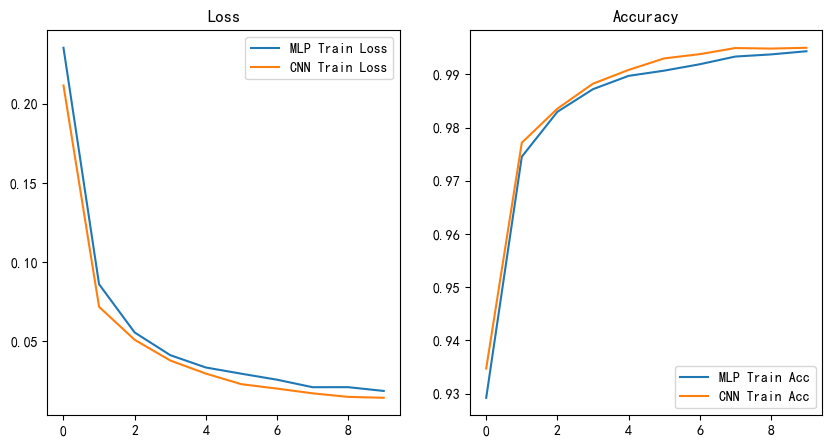

In [17]:
# 将训练过程中的损失与准确率可视化
# mlp对比cnn
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_train_info[0], label='MLP Train Loss')
plt.plot(train_info[0], label='CNN Train Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(mlp_train_info[1], label='MLP Train Acc')
plt.plot(train_info[1], label='CNN Train Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_info[0], label='Train Loss')
# plt.title('Loss')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(train_info[1], label='Train Acc')
# plt.title('Accuracy')
# plt.legend()
# plt.show()

In [ ]:
plt.plot(mlp_train_info[0], label='MLP Train Loss')
plt.plot(train_info[0], label='CNN Train Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(mlp_train_info[1], label='MLP Train Acc')
plt.plot(train_info[1], label='CNN Train Acc')
plt.title('Accuracy')
plt.legend()
plt.show()